# U-Net

### Initial imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import keras
from keras.layers import Input, Conv2D, Flatten, Conv2DTranspose, Dense, ZeroPadding2D, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping

### Loading images

In [2]:
# Dataset dependant parameters
data_path = "data/3ball/"
num_systems = 10000
num_balls = 3
pix = 32

X1 = []
for i in tqdm(glob(data_path + "Input/image1_*.png")):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    im = keras.utils.img_to_array(im)
    X1.append(im)
X1 = np.array(X1, dtype="float32") / 255

X2 = []
for i in tqdm(glob(data_path + "Input/image2_*.png")):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    im = keras.utils.img_to_array(im)
    X2.append(im)
X2 = np.array(X2, dtype="float32") / 255

Y = []
for i in tqdm(glob(data_path + "Output/*.png")):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    im = keras.utils.img_to_array(im)
    Y.append(im)
Y = np.array(Y, dtype="float32") / 255

100%|██████████| 10000/10000 [00:04<00:00, 2125.55it/s]


### Temperature computation and data split

In [3]:
coordinates = np.loadtxt(data_path + 'coordinates.csv', delimiter=',')
coordinates = coordinates[:, -2*num_balls:] / 4

temperature = np.zeros((num_systems))

for i in range(num_systems):
    for j in range(num_balls):
        # Add the speed of each ball to the temperature
        temperature[i] += np.sqrt(np.sum(np.square(coordinates[i, 2*j : 2*(j+1)])))
    
    # Divide by number of balls to get the mean
    temperature[i] /= num_balls

# Concatenate both frames
X = np.concatenate((X1, X2), axis=3)
# Train-val-test split (80-10-10)
x_train, x_test, y_train, y_test, temperature_train, temperature_test = train_test_split(X, Y, temperature, test_size=0.2)
x_val, x_test, y_val, y_test, temperature_val, temperature_test = train_test_split(x_test, y_test, temperature_test, test_size=0.5)

### Model definition and training

In [4]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, (3,3), activation="relu", padding="same")(x)
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, (3,3), activation="relu", padding="same")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = ZeroPadding2D(padding=(1, 1))(f)
   p = Conv2D(n_filters, (3,3), activation="relu", strides = (2,2))(p)
   return f, p

def upsample_block(x, conv_features, n_filters, drop_pct=0):
   # upsample
   x = Conv2DTranspose(n_filters, (2,2), (2,2), padding="same")(x)
   # concatenate
   x = keras.layers.concatenate([x, conv_features])
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x


# Input layer
inputs = Input(shape=(pix,pix,2))

# Encoder layers
f1, p1 = downsample_block(inputs, 1)
f2, p2 = downsample_block(p1, 1)
f3, p3 = downsample_block(p2, 1)
f4, p4 = downsample_block(p3, 1)

# Bottleneck layer
bottleneck = double_conv_block(p4, 1)

# Decoder layers
u6 = upsample_block(bottleneck, f4, 1)
u7 = upsample_block(u6, f3, 1)
u8 = upsample_block(u7, f2, 1)
u9 = upsample_block(u8, f1, 1)

# Output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(u9)

unet_model = Model(inputs, outputs, name="U-Net")
unet_model.summary()

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 2)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 1)    19          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 1)    10          ['conv2d[0][0]']                 
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 34, 34, 1)   0           ['conv2d_1[0][0]']               
                                                                                              

In [5]:
unet_model.compile(optimizer='adam', loss='mse')

unet_model.fit(x_train, y_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(x_val, y_val),
                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)])

Epoch 1/100
250/250 [==============================] - 22s 44ms/step - loss: 0.1196 - val_loss: 0.0219
Epoch 2/100
250/250 [==============================] - 7s 28ms/step - loss: 0.0217 - val_loss: 0.0213
Epoch 3/100
250/250 [==============================] - 7s 28ms/step - loss: 0.0209 - val_loss: 0.0204
Epoch 4/100
250/250 [==============================] - 7s 28ms/step - loss: 0.0200 - val_loss: 0.0194
Epoch 5/100
250/250 [==============================] - 7s 28ms/step - loss: 0.0191 - val_loss: 0.0185
Epoch 6/100
250/250 [==============================] - 7s 28ms/step - loss: 0.0183 - val_loss: 0.0178
Epoch 7/100
250/250 [==============================] - 8s 32ms/step - loss: 0.0178 - val_loss: 0.0173
Epoch 8/100
250/250 [==============================] - 8s 32ms/step - loss: 0.0173 - val_loss: 0.0167
Epoch 9/100
250/250 [==============================] - 9s 34ms/step - loss: 0.0167 - val_loss: 0.0162
Epoch 10/100
250/250 [==============================] - 10s 40ms/step - loss: 0.0

### Model reconstructions

We print (from left to right) the 3 frames of the sample (2 inputs and output), an auxiliar image to see of how much movement there is between the first and final frame, the reconstructed image and the 3rd frame over the reconstructed image. This last image is useful to see if the position of the balls is accurately predicted.

32/32 [==============================] - 1s 25ms/step


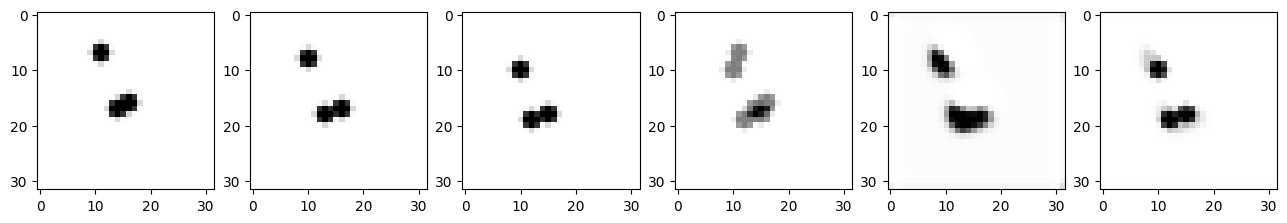

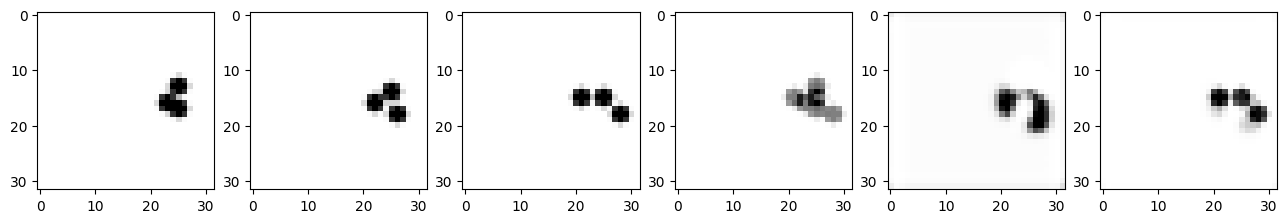

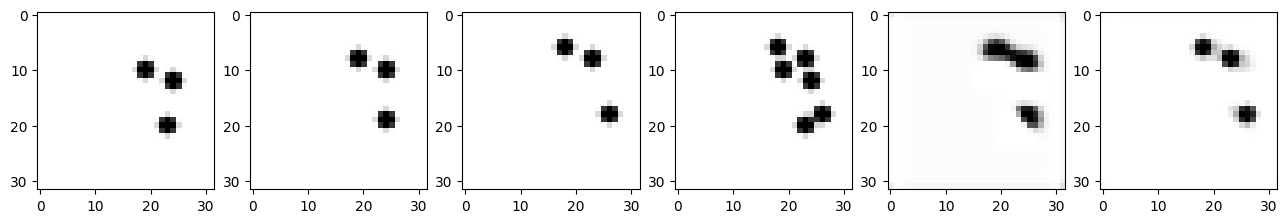

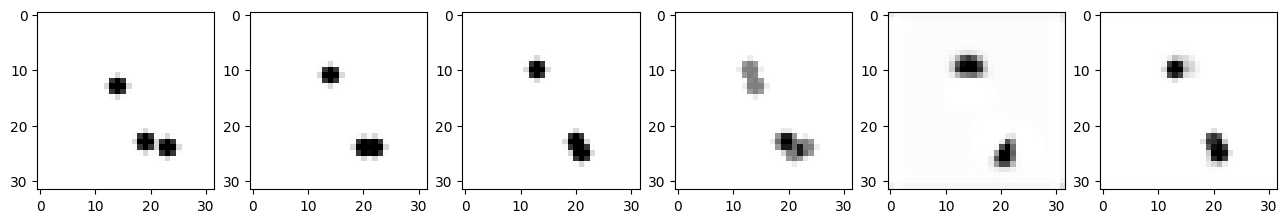

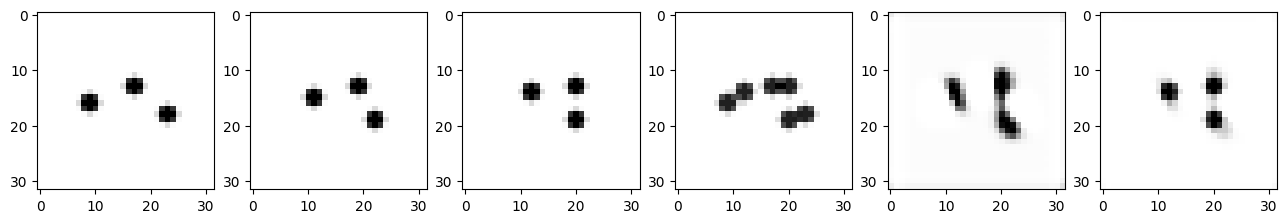

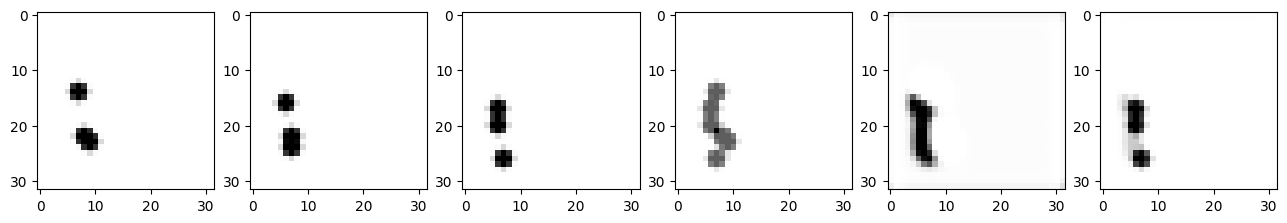

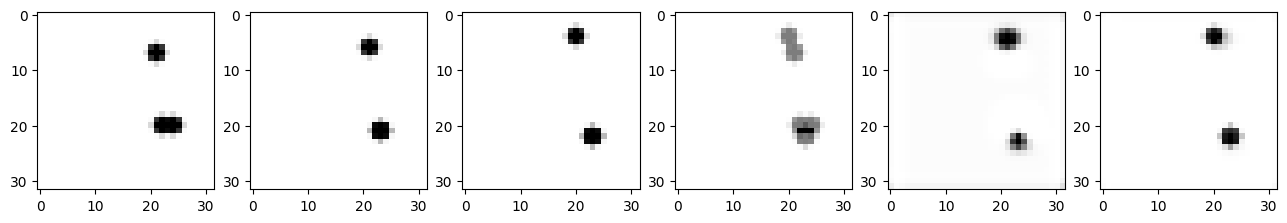

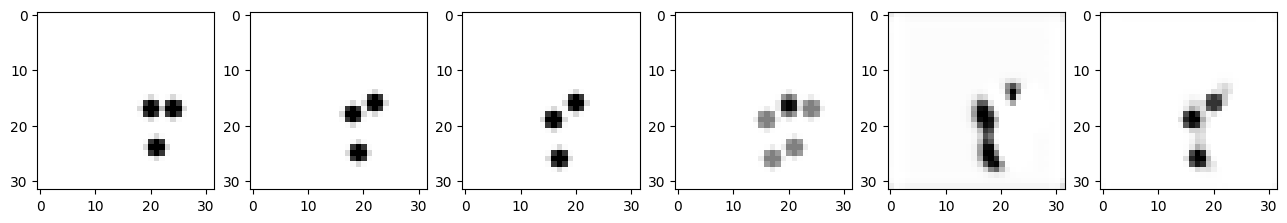

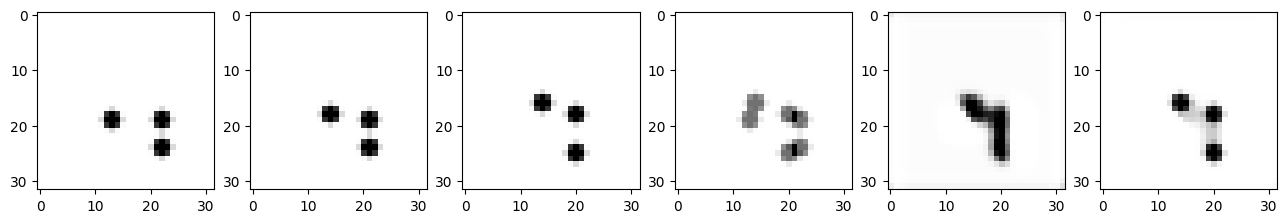

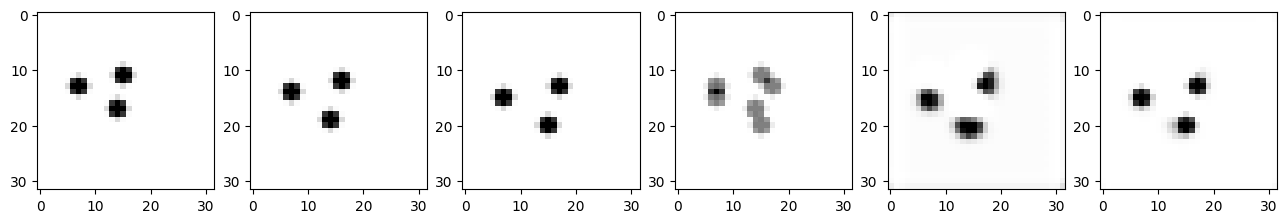

In [6]:
predictions = unet_model.predict(x_test)

for i in range(10):
    plt.figure(figsize=(16, 96))
    # First image
    plt.subplot(1, 6, 1)
    plt.imshow(x_test[i,:,:,0].reshape(pix, pix), cmap='gray')

    # Second image
    plt.subplot(1, 6, 2)
    plt.imshow(x_test[i,:,:,1].reshape(pix, pix), cmap='gray')

    # Third image
    plt.subplot(1, 6, 3)
    plt.imshow(y_test[i].reshape(pix, pix), cmap='gray')

    # Balls in first and final frame to check how much movement there is on that sample
    plt.subplot(1, 6, 4)
    plt.imshow(y_test[i].reshape(pix, pix) + x_test[i,:,:,0].reshape(pix, pix), cmap='gray')

    # Predicted image
    plt.subplot(1, 6, 5)
    plt.imshow(predictions[i].reshape(pix, pix), cmap='gray')

    # Image to predict over reconstruction
    plt.subplot(1, 6, 6)
    plt.imshow(y_test[i].reshape(pix, pix) + predictions[i].reshape(pix, pix)/2, cmap='gray')

    plt.show()

### Temperature regression

We will try to regress the temperature of the system with the activation weights of the last concatenation layer (it should have all the information from the skip connections and the downsample and umpsample path).

In [7]:
last_layer = Model(inputs=unet_model.input, outputs=unet_model.get_layer('concatenate_3').output)

# Get the encoded representation of the images in train, validation and test sets
encoded_imgs_train = last_layer.predict(x_train)
encoded_imgs_val = last_layer.predict(x_val)
encoded_imgs_test = last_layer.predict(x_test)

# Reshape to vectors (flatten)
encoded_imgs_train_flat = encoded_imgs_train.reshape((encoded_imgs_train.shape[0], -1))
encoded_imgs_val_flat = encoded_imgs_val.reshape((encoded_imgs_val.shape[0], -1))
encoded_imgs_test_flat = encoded_imgs_test.reshape((encoded_imgs_test.shape[0], -1))

32/32 [==============================] - 1s 18ms/step


### Investigating the activation layers

We have a look at the activation layers to try to understand what is happening inside the neural network.

1/1 [==============================] - 1s 601ms/step
input_1


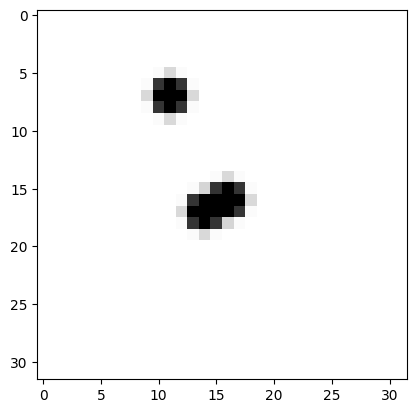

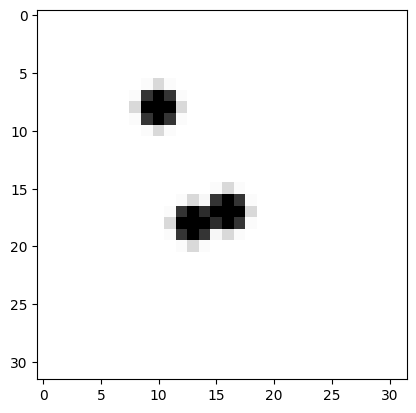

conv2d


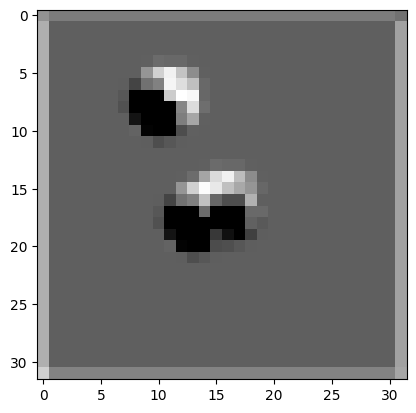

conv2d_1


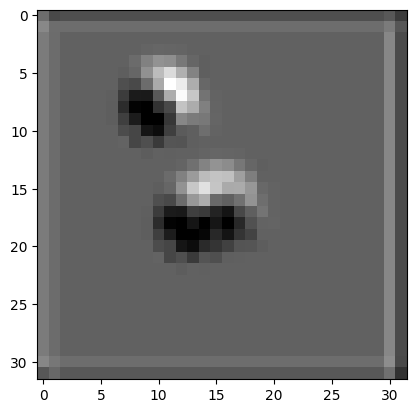

zero_padding2d


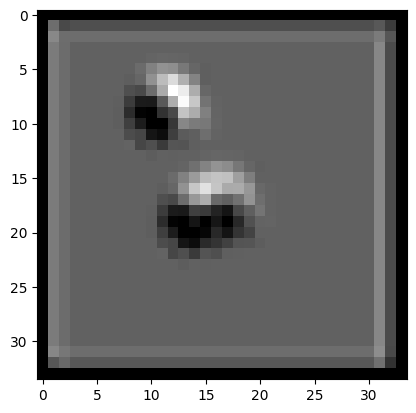

conv2d_2


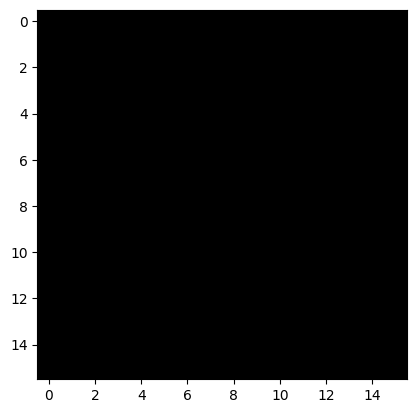

conv2d_3


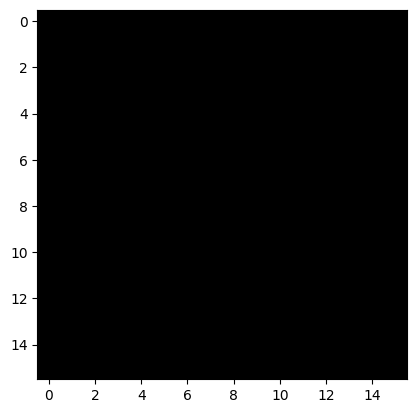

conv2d_4


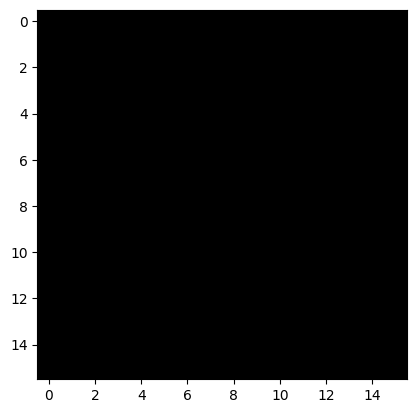

zero_padding2d_1


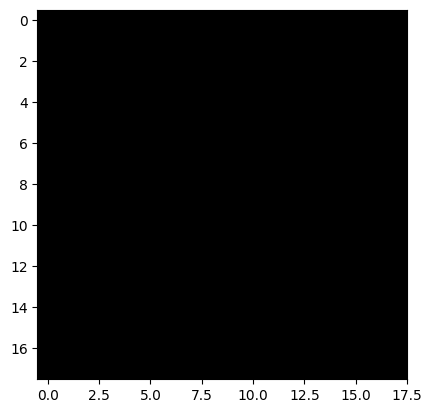

conv2d_5


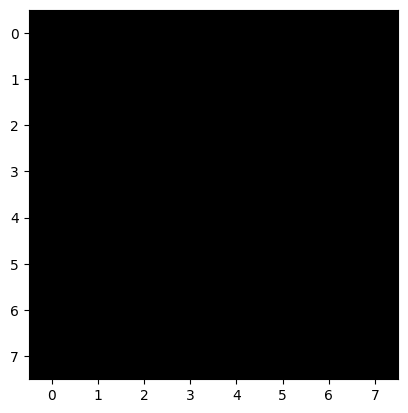

conv2d_6


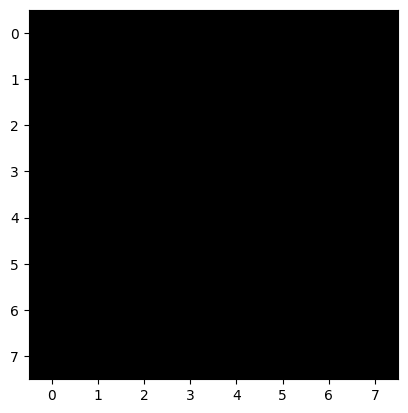

conv2d_7


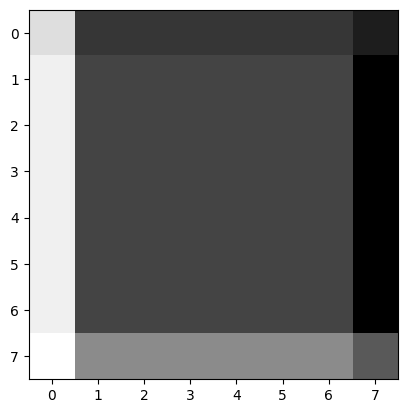

zero_padding2d_2


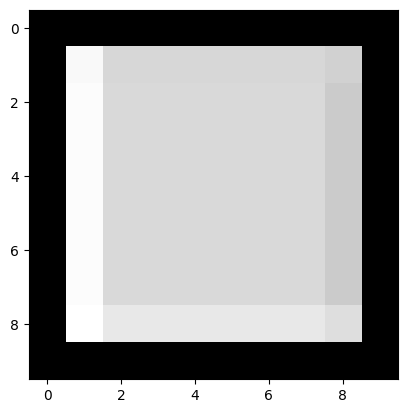

conv2d_8


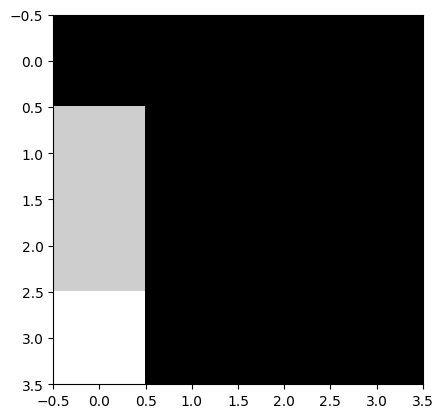

conv2d_9


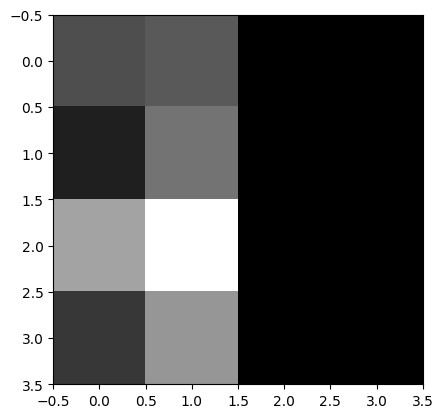

conv2d_10


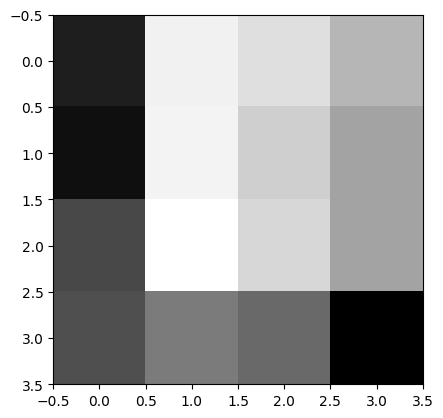

zero_padding2d_3


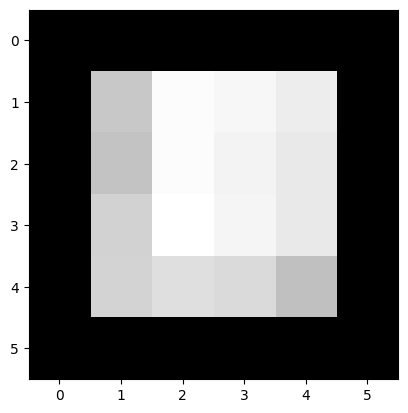

conv2d_11


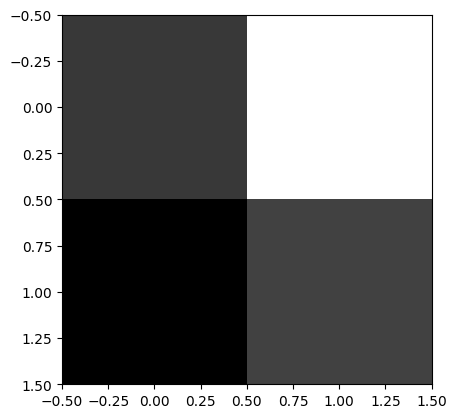

conv2d_12


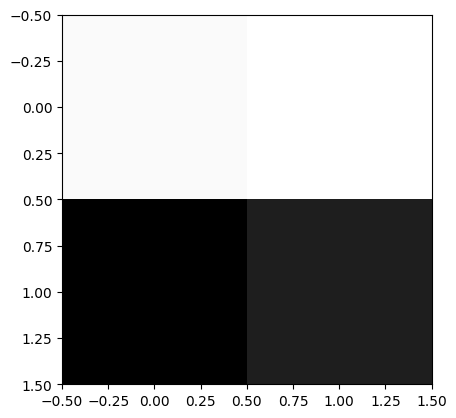

conv2d_13


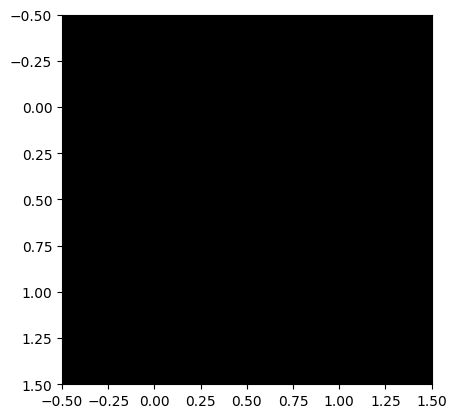

conv2d_transpose


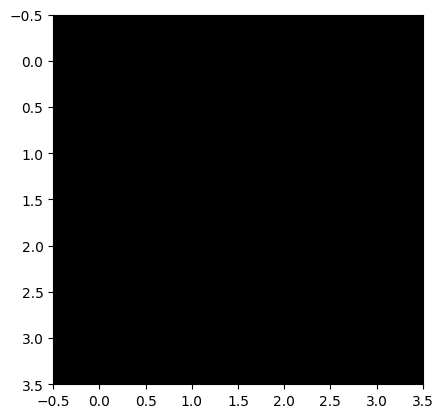

concatenate


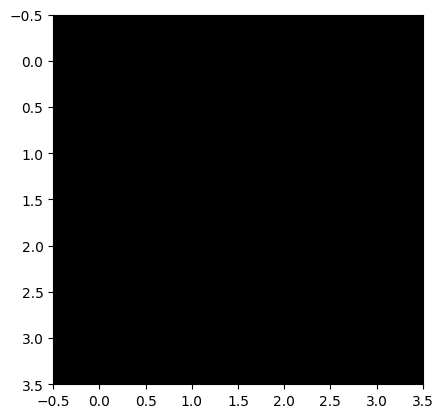

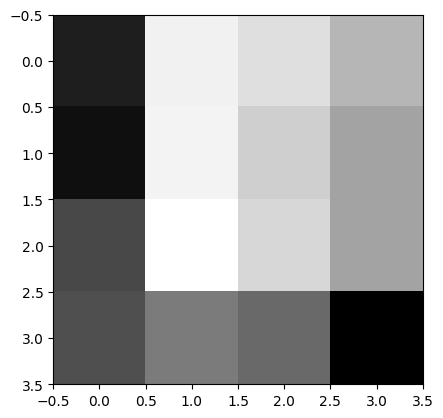

conv2d_14


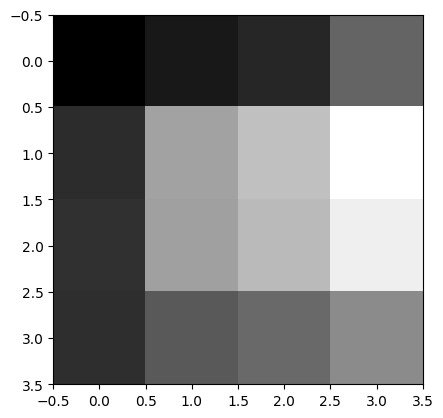

conv2d_15


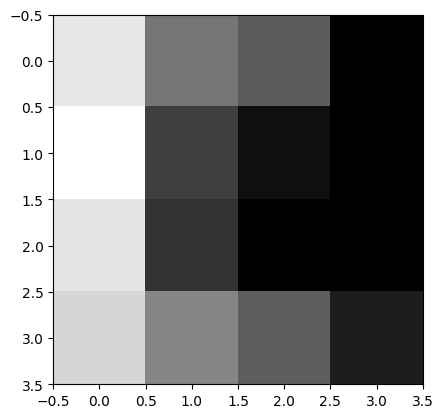

conv2d_transpose_1


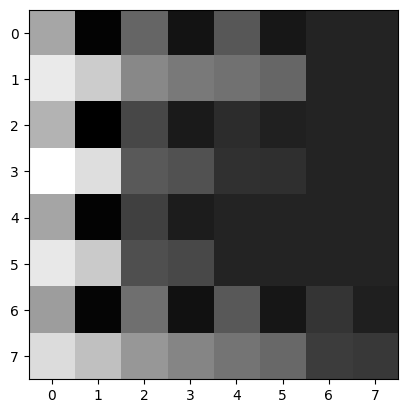

concatenate_1


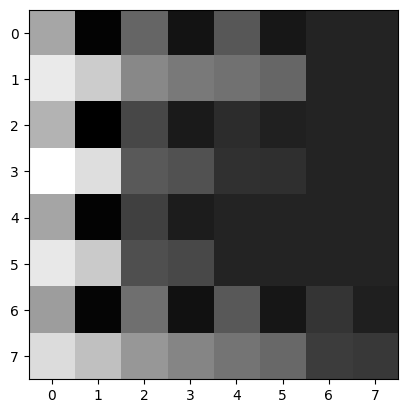

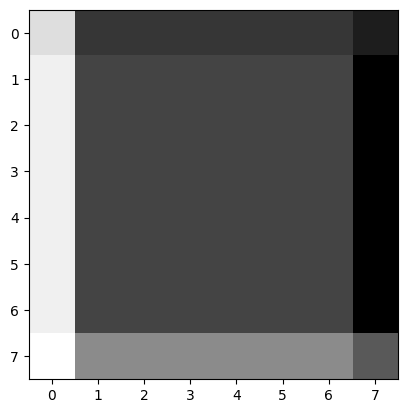

conv2d_16


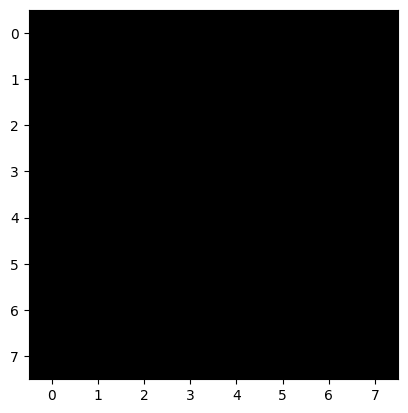

conv2d_17


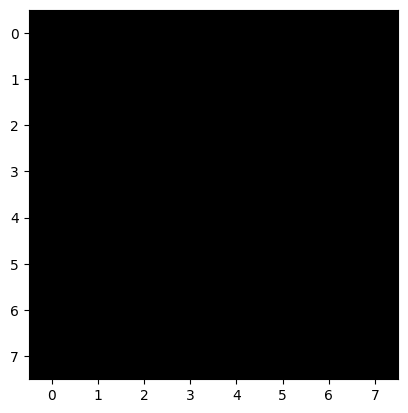

conv2d_transpose_2


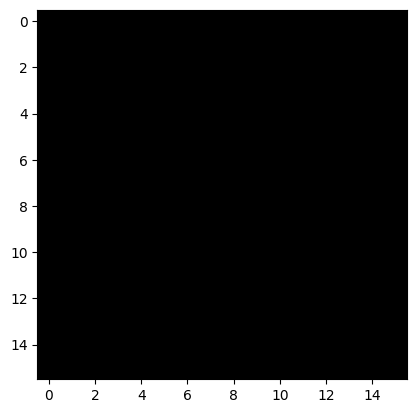

concatenate_2


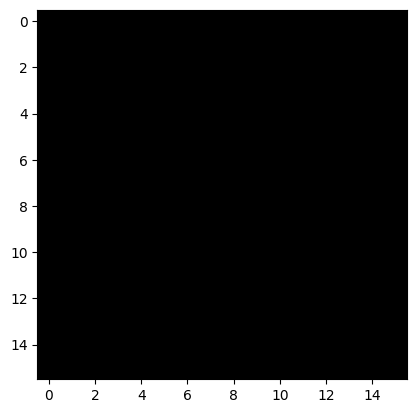

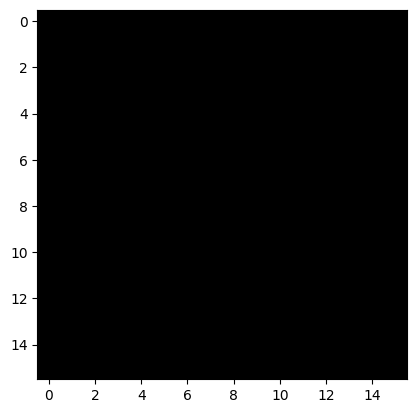

conv2d_18


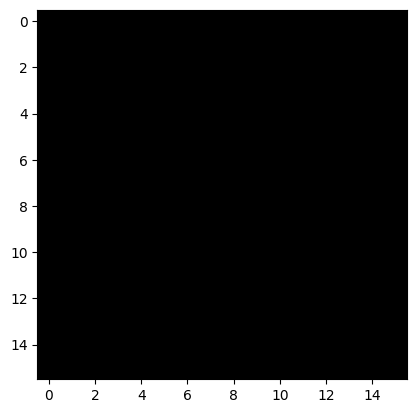

conv2d_19


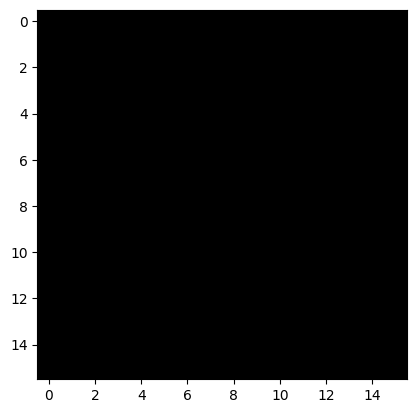

conv2d_transpose_3


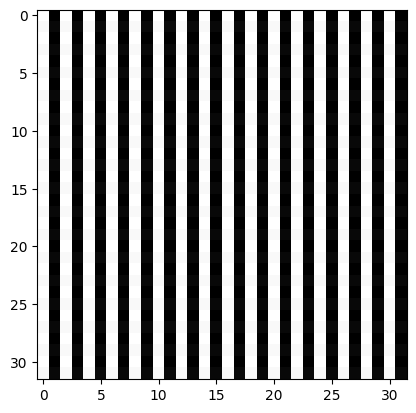

concatenate_3


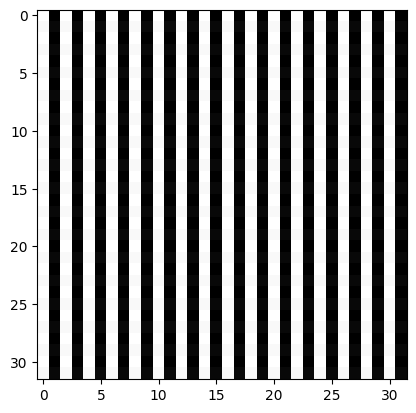

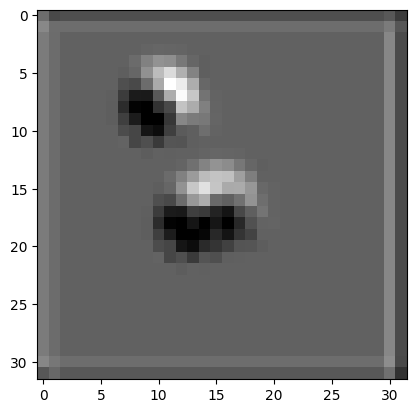

conv2d_20


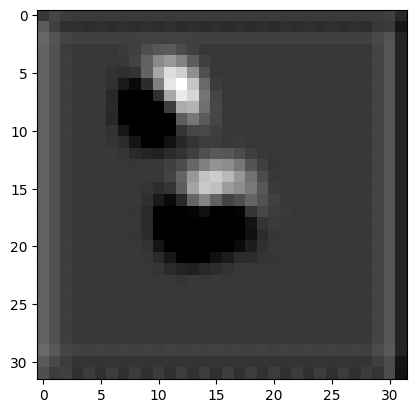

conv2d_21


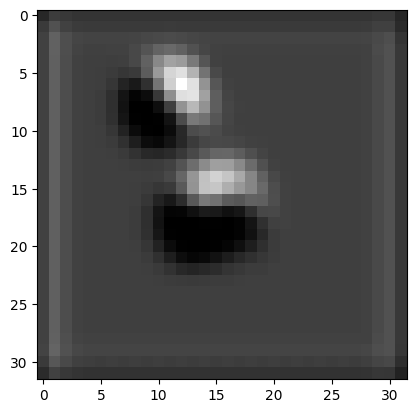

conv2d_22


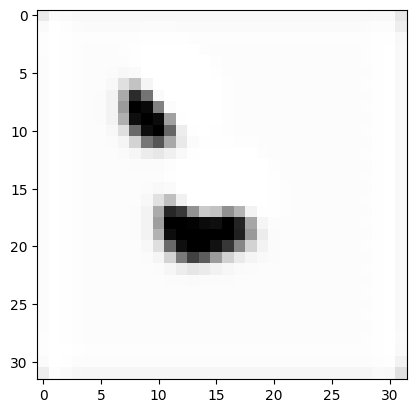

In [8]:
# Get all the layers of the model
layers = unet_model.layers

outputs = [layer.output for layer in layers]
layer_outputs = Model(inputs=unet_model.input, outputs=outputs)

layer_outputs = layer_outputs.predict(x_test[0].reshape(1, pix, pix, 2))

# Print the output of each layer
for i, output in enumerate(layer_outputs):
    if layers[i].name in ['dense', 'reshape', 'flatten', 'dense_1']:
        continue
    print(layers[i].name)
    for j in range(output.shape[3]):
        plt.imshow(output[:,:,:,j].reshape(output.shape[1], output.shape[2]), cmap='gray')
        plt.show()
        plt.close()

As we can see the two paths are not needed since one is just sending noise or useless information. Additionally, we can see some checkerboard artifacts in some activation layers.

#### Linear Regression

In [9]:
temperature_regressor_1 = LinearRegression()
temperature_regressor_1.fit(encoded_imgs_train_flat, temperature_train)
score = mean_squared_error(temperature_val, temperature_regressor_1.predict(encoded_imgs_val_flat))
print('MSE: ' + str(score))

temperature_predictions = temperature_regressor_1.predict(encoded_imgs_test_flat)

for i in range(5):
    print('Sample ' + str(i) + '\nPrediction: ' + str(temperature_predictions[i]) + '\nActual temperature: ' + str(temperature_test[i]))

MSE: 647.2506535823488
Sample 0
Prediction: 0.29882812
Actual temperature: 0.25
Sample 1
Prediction: 0.26367188
Actual temperature: 0.2845177968644246
Sample 2
Prediction: 0.41601562
Actual temperature: 0.5393446629166316
Sample 3
Prediction: 0.51171875
Actual temperature: 0.4708567949894071
Sample 4
Prediction: 0.46289062
Actual temperature: 0.4560113295832983


#### Convolution + FC

In [10]:
inputs = Input(shape=(pix,pix,2))

x = Conv2D(1, (3,3), activation="relu")(inputs)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dense(16, activation="relu")(x)

outputs = Dense(1, activation="sigmoid")(x)

temperature_regressor_2 = Model(inputs, outputs, name="ConvAndFC")

temperature_regressor_2.summary()

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

Model: "ConvAndFC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 1)         19        
                                                                 
 flatten (Flatten)           (None, 900)               0         
                                                                 
 dense (Dense)               (None, 128)               115328    
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 117,428
Trainable params: 117,428
Non-train

In [11]:
temperature_regressor_2.compile(optimizer='adam', loss='mse')

temperature_regressor_2.fit(encoded_imgs_train, temperature_train,
                             epochs=100,
                             batch_size=32,
                             shuffle=True,
                             validation_data=(encoded_imgs_val, temperature_val),
                             callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.001)])

Epoch 1/100
250/250 [==============================] - 6s 15ms/step - loss: 0.0639 - val_loss: 0.0354
Epoch 2/100
250/250 [==============================] - 3s 10ms/step - loss: 0.0283 - val_loss: 0.0223
Epoch 3/100
250/250 [==============================] - 3s 11ms/step - loss: 0.0130 - val_loss: 0.0093
Epoch 4/100
250/250 [==============================] - 3s 10ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 5/100
250/250 [==============================] - 3s 11ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 6/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0087 - val_loss: 0.0090
Epoch 7/100
250/250 [==============================] - 3s 13ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 8/100
250/250 [==============================] - 3s 11ms/step - loss: 0.0084 - val_loss: 0.0084


In [12]:
temperature_predictions = temperature_regressor_2.predict(encoded_imgs_test)

for i in range(5):
    print('Sample ' + str(i) + '\nPrediction: ' + str(temperature_predictions[i]) + '\nActual temperature: ' + str(temperature_test[i]))

32/32 [==============================] - 0s 7ms/step
Sample 0
Prediction: [0.34335652]
Actual temperature: 0.25
Sample 1
Prediction: [0.30620652]
Actual temperature: 0.2845177968644246
Sample 2
Prediction: [0.51283795]
Actual temperature: 0.5393446629166316
Sample 3
Prediction: [0.41623622]
Actual temperature: 0.4708567949894071
Sample 4
Prediction: [0.46599507]
Actual temperature: 0.4560113295832983


#### Only Fully-Connected

In [13]:
inputs = Input(shape=(pix*pix*2))

x = Dense(128, activation="relu")(inputs)
x = Dense(16, activation="relu")(x)
x = Dropout(0.3)(x)

outputs = Dense(1, activation="sigmoid")(x)

temperature_regressor_3 = Model(inputs, outputs, name="FC")

temperature_regressor_3.summary()

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

Model: "FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 264,353
Trainable params: 264,353
Non-trainable params: 0
_________________________________________________________________


In [14]:
temperature_regressor_3.compile(optimizer='adam', loss='mse')

temperature_regressor_3.fit(encoded_imgs_train_flat, temperature_train,
                             epochs=100,
                             batch_size=32,
                             shuffle=True,
                             validation_data=(encoded_imgs_val_flat, temperature_val),
                             callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.001)])

Epoch 1/100
250/250 [==============================] - 5s 12ms/step - loss: 0.0317 - val_loss: 0.0314
Epoch 2/100
250/250 [==============================] - 3s 13ms/step - loss: 0.0305 - val_loss: 0.0314
Epoch 3/100
250/250 [==============================] - 3s 11ms/step - loss: 0.0305 - val_loss: 0.0314
Epoch 4/100
250/250 [==============================] - 3s 13ms/step - loss: 0.0305 - val_loss: 0.0314
Epoch 5/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0305 - val_loss: 0.0314
Epoch 6/100
250/250 [==============================] - 3s 12ms/step - loss: 0.0305 - val_loss: 0.0314


In [15]:
temperature_predictions = temperature_regressor_3.predict(encoded_imgs_test_flat)

for i in range(5):
    print('Sample ' + str(i) + '\nPrediction: ' + str(temperature_predictions[i]) + '\nActual temperature: ' + str(temperature_test[i]))

32/32 [==============================] - 0s 3ms/step
Sample 0
Prediction: [0.5049813]
Actual temperature: 0.25
Sample 1
Prediction: [0.5049813]
Actual temperature: 0.2845177968644246
Sample 2
Prediction: [0.5049813]
Actual temperature: 0.5393446629166316
Sample 3
Prediction: [0.5049813]
Actual temperature: 0.4708567949894071
Sample 4
Prediction: [0.5049813]
Actual temperature: 0.4560113295832983
